# Metal Abundance Distribution

In [3]:
import os
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"

In [4]:
from multiprocessing import Pool
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
from scipy.stats import binned_statistic
from scipy.stats import gaussian_kde
import yaml

/u/fiza/conda-envs/auriga/lib/python3.7/site-packages/setuptools/_importlib.py:23: UserWarning: `importlib-metadata` version is incompatible with `setuptools`.
This problem is likely to be solved by installing an updated version of `importlib-metadata`.
  warnings.warn(msg)  # Ensure a descriptive message is shown.


In [5]:
from auriga.snapshot import Snapshot
from auriga.images import figure_setup
from auriga.settings import Settings
from auriga.parser import parse

In [33]:
figure_setup()
settings = Settings()

In [7]:
CONFIG_FILE = "02"

In [8]:
config = yaml.safe_load(open(f"../configs/{CONFIG_FILE}.yml"))

In [9]:
def read_data(simulation: str, of: str, to: str,
              tag_in_situ: bool = False) -> tuple:
    settings = Settings()

    s = Snapshot(simulation=simulation, loadonlytype=[0, 1, 2, 3, 4, 5])
    s.tag_particles_by_region(
        disc_std_circ=config["DISC_STD_CIRC"],
        disc_min_circ=config["DISC_MIN_CIRC"],
        cold_disc_delta_circ=config["COLD_DISC_DELTA_CIRC"],
        bulge_max_specific_energy=config["BULGE_MAX_SPECIFIC_ENERGY"])
    s.add_metal_abundance(of, to)
    
    is_real_star = (s.type == 4) & (s.stellar_formation_time > 0)
    is_main_obj = (s.halo == s.halo_idx) & (s.subhalo == s.subhalo_idx)

    df = pd.DataFrame()
    df[f"[{of}/{to}]"] = s.metal_abundance[
        f"{of}/{to}"][is_real_star & is_main_obj]
    df["RegionTag"] = s.region_tag[is_real_star & is_main_obj]

    if tag_in_situ:
        s.tag_in_situ_stars()
        df["IsInSitu"] = s.is_in_situ[
            is_real_star & is_main_obj].astype("bool")

    return df

In [10]:
def plot_distribution_for_galaxy_with_stellar_origin(
    simulation: str, of: str, to: str,
    xlim: tuple, ylim: tuple, xticks: list) -> None:

    galaxy = parse(simulation)[0]
    df = read_data(simulation=simulation, of=of, to=to, tag_in_situ=True)

    fig = plt.figure(figsize=(7.4, 2.0))
    gs = fig.add_gridspec(nrows=1, ncols=4, hspace=0.0, wspace=0.0)
    axs = gs.subplots(sharex=True, sharey=True)

    for ax in axs.flat:
        ax.tick_params(which='both', direction="in")
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.set_xticks(xticks)
        ax.set_xlabel(f'[{of}/{to}]')
        ax.set_ylabel(r"$f_\star$")
        ax.grid(True, ls='-', lw=0.25, c="gainsboro")
        ax.label_outer()

    for idx, component in enumerate(settings.components):

        n_stars_comp = (df["RegionTag"] == idx).sum()

        hist, bin_edges = np.histogram(
            a=df[f"[{of}/{to}]"][df["RegionTag"] == idx],
            bins=config["ABUNDANCE_DISTRIBUTION"]["N_BINS"], range=xlim)
        bin_centers = bin_edges[1:] - np.diff(bin_edges)[0] / 2
        axs[idx].plot(
            bin_centers, hist / n_stars_comp, zorder=11,
            c=settings.component_colors[component], lw=2)

        hist, _ = np.histogram(
            a=df[f"[{of}/{to}]"][
                (df["RegionTag"] == idx) & (df["IsInSitu"] == 1)],
            bins=config["ABUNDANCE_DISTRIBUTION"]["N_BINS"], range=xlim)
        axs[idx].plot(
            bin_centers, hist / n_stars_comp, zorder=11,
            c='k', lw=0.75, ls=(0, (3, 1.5, 1, 1.5)), label="In-Situ Stars")

        hist, _ = np.histogram(
            a=df[f"[{of}/{to}]"][
                (df["RegionTag"] == idx) & (df["IsInSitu"] == 0)],
            bins=config["ABUNDANCE_DISTRIBUTION"]["N_BINS"], range=xlim)
        axs[idx].plot(
            bin_centers, hist / n_stars_comp, zorder=11,
            c='k', lw=0.75, ls=(0, (5, 1.5)), label="Ex-Situ Stars")

        axs[idx].text(
            x=0.05, y=0.95, size=8.0, ha="left", va="top",
            s=r"$\textbf{" + list(settings.component_labels.values())[idx] \
                + "}$",
            c=list(settings.component_colors.values())[idx],
            transform=axs[idx].transAxes)

    axs[3].legend(loc="lower left", framealpha=0, fontsize=6,
                    bbox_to_anchor=(0.009, 0.65))

    axs[0].text(
        x=0.95, y=0.95, size=8.0,
        s=r"$\texttt{" + f"Au{galaxy}" + "}$",
        ha='right', va='top', transform=axs[0].transAxes)

    fig.savefig(
        f"../images/metal_abundance_distribution/{of}_{to}/"
        f"with_stellar_origin/{simulation}{config['FILE_SUFFIX']}.pdf")
    plt.close(fig)

In [11]:
def plot_distribution_for_galaxy(
    simulation: str, of: str, to: str,
    xlim: tuple, ylim: tuple, xticks: list) -> None:

    galaxy = parse(simulation)[0]
    df = read_data(simulation=simulation, of=of, to=to, tag_in_situ=True)

    fig, ax = plt.subplots(figsize=(2.5, 2.5))

    ax.tick_params(which='both', direction="in")
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xticks(xticks)
    ax.set_xlabel(f'[{of}/{to}]')
    ax.set_ylabel("PDF")
    ax.grid(True, ls='-', lw=0.25, c="gainsboro")

    for idx, component in enumerate(settings.components):
        is_region = (df["RegionTag"] == idx)
        is_finite = np.isfinite(df[f"[{of}/{to}]"])

        pdf = gaussian_kde(df[f"[{of}/{to}]"][is_region & is_finite].to_numpy(
            dtype=np.float64))
        pdf_x = np.linspace(xlim[0], xlim[1], 100)
        pdf_y = pdf(pdf_x)
        ax.plot(pdf_x, pdf_y, lw=1.0,
            color=settings.component_colors[component],
            label=settings.component_labels[component],
            zorder=15)

    ax.legend(loc="upper left", framealpha=0, fontsize=6)

    ax.text(
        x=0.95, y=0.95, size=8.0,
        s=r"$\texttt{" + f"Au{galaxy}" + "}$",
        ha='right', va='top', transform=ax.transAxes)

    fig.savefig(
        f"../images/metal_abundance_distribution/{of}_{to}/"
        f"{simulation}{config['FILE_SUFFIX']}.pdf")
    plt.close(fig)

In [12]:
def plot_distribution_for_sample(simulations: list,
    of: str, to: str, xlim: tuple, ylim: tuple,
    xticks: list, yticks: list) -> None:

    fig = plt.figure(figsize=(7, 8))
    gs = fig.add_gridspec(nrows=6, ncols=4, hspace=0.0, wspace=0.0)
    axs = gs.subplots(sharex=True, sharey=True)

    for ax in axs.flat:
        ax.tick_params(which='both', direction="in")
        if ax == axs[-1, -1]: ax.axis("off")
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.set_xticks(xticks)
        ax.set_yticks(yticks)
        ax.grid(True, ls='-', lw=0.25, c="gainsboro")
        ax.set_axisbelow(True)
        if ax.get_subplotspec().is_last_row() or ax == axs[-2, -1]:
            ax.set_xlabel(f'[{of}/{to}]')
            ax.tick_params(labelbottom=True)
        if ax.get_subplotspec().is_first_col():
            ax.set_ylabel("PDF")

    for i, simulation in enumerate(simulations):
        df = read_data(simulation=simulation, of=of, to=to)
        ax = axs.flatten()[i]

        for region_tag in range(4):
            is_region = (df["RegionTag"] == region_tag)
            is_finite = np.isfinite(df[f"[{of}/{to}]"])

            pdf = gaussian_kde(df[f"[{of}/{to}]"][
                is_region & is_finite].to_numpy(
                    dtype=np.float64))
            pdf_x = np.linspace(xlim[0], xlim[1], 100)
            pdf_y = pdf(pdf_x)
            ax.plot(
                pdf_x, pdf_y, lw=1.0,
                color=settings.component_colors[
                    settings.components[region_tag]],
                label=settings.component_labels[
                    settings.components[region_tag]],
                zorder=15)

        galaxy = parse(simulation)[0]
        ax.text(
            x=0.95, y=0.95, size=6.0,
            s=r"$\texttt{" + f"Au{galaxy}" + "}$",
            ha='right', va='top', transform=ax.transAxes)

        if i == 0:
            ax.legend(loc="upper left", framealpha=0, fontsize=4)

        fig.savefig(
            f"../images/metal_abundance_distribution/{of}_{to}/"
            f"included{config['FILE_SUFFIX']}.pdf")
        plt.close(fig)

In [13]:
def plot_three_panel_distribution_for_galaxy(simulation: str) -> None:

    fe_vs_h = read_data(
        simulation=simulation, of="Fe", to='H', tag_in_situ=False)
    o_vs_h = read_data(
        simulation=simulation, of='O', to='H', tag_in_situ=False)
    o_vs_fe = read_data(
        simulation=simulation, of='O', to="Fe", tag_in_situ=False)
    dfs = [fe_vs_h, o_vs_h, o_vs_fe]

    fig = plt.figure(figsize=(3.0, 6.0))
    gs = fig.add_gridspec(nrows=3, ncols=1, hspace=0.4, wspace=0.0)
    axs = gs.subplots(sharex=False, sharey=False)
    abundances = ["[Fe/H]", "[O/H]", "[O/Fe]"]

    for i, ax in enumerate(axs):
        ax.tick_params(which='both', direction="in")
        ax.set_ylim(0, 1)
        ax.set_xlabel(abundances[i])
        ax.set_ylabel("PDF")
        ax.grid(True, ls='-', lw=0.25, c="gainsboro")

    axs[0].set_xlim(-2, 1)
    axs[0].set_xticks([-2, -1.5, -1, -0.5, 0, 0.5, 1])
    axs[0].set_ylim(0, 2)
    axs[1].set_xlim(-2, 1)
    axs[1].set_xticks([-2, -1.5, -1, -0.5, 0, 0.5, 1])
    axs[1].set_ylim(0, 2)
    axs[2].set_xlim(0.1, 0.4)
    axs[2].set_xticks([0.1, 0.2, 0.3, 0.4])
    axs[2].set_ylim(0, 20)

    for i in range(len(dfs)):
        ax = axs[i]
        df = dfs[i]
        abundance = abundances[i]
        for idx, component in enumerate(settings.components):
            is_region = (df["RegionTag"] == idx)
            is_finite = np.isfinite(df[abundance])
            pdf = gaussian_kde(
                df[abundance][is_region & is_finite].to_numpy(
                    dtype=np.float64))
            pdf_x = np.linspace(ax.get_xlim()[0], ax.get_xlim()[1], 100)
            ax.plot(pdf_x, pdf(pdf_x), lw=1.0,
                    color=settings.component_colors[component],
                    label=settings.component_labels[component],
                    zorder=15)

    axs[0].legend(loc="upper left", framealpha=0, fontsize=6)

    galaxy = parse(simulation)[0]
    axs[0].text(
        x=0.95, y=0.95, size=8.0,
        s=r"$\texttt{" + f"Au{galaxy}" + "}$",
        ha='right', va='top', transform=axs[0].transAxes)

    fig.savefig(
        f"../images/metal_abundance_distribution/three_panels_"
        f"{simulation}{config['FILE_SUFFIX']}.pdf")
    plt.close(fig)

In [14]:
def plot_distribution_for_sample_highlight(simulations: list,
    of: str, to: str, highlight: str, **kwargs) -> None:

    fig = plt.figure(figsize=(7.4, 2.0))
    gs = fig.add_gridspec(nrows=1, ncols=4, hspace=0.0, wspace=0.0)
    axs = gs.subplots(sharex=True, sharey=True)

    for ax in axs.flat:
        ax.tick_params(which='both', direction="in")
        if "xlim" in kwargs: ax.set_xlim(kwargs["xlim"])
        if "ylim" in kwargs: ax.set_ylim(kwargs["ylim"])
        if "xticks" in kwargs: ax.set_xticks(kwargs["xticks"])
        if "yticks" in kwargs: ax.set_yticks(kwargs["yticks"])
        ax.set_xlabel(f'[{of}/{to}]')
        ax.set_ylabel("PDF")
        ax.grid(True, ls='-', lw=0.25, c="gainsboro")
        ax.label_outer()
    
    for i, component in enumerate(settings.components):
        ax = axs.flatten()[i]
        ax.text(
            x=0.05, y=0.95, size=8.0, ha="left", va="top",
            s=r"$\textbf{" + settings.component_labels[component] + "}$",
            c=settings.component_colors[component], transform=ax.transAxes)

    for simulation in simulations:
        galaxy = parse(simulation)[0]
        df = read_data(simulation=simulation, of=of, to=to)

        if simulation == highlight:
            zorder = 16
            label = f"Au{galaxy}"
        else:
            zorder = 15
            label = None

        for j, component in enumerate(settings.components):

            if simulation == highlight:
                color = settings.component_colors[settings.components[j]]
            else:
                color = "silver"

            ax = axs.flatten()[j]
            is_region = (df["RegionTag"] == j)
            is_finite = np.isfinite(df[f"[{of}/{to}]"])

            pdf = gaussian_kde(df[f"[{of}/{to}]"][
                is_region & is_finite].to_numpy(
                    dtype=np.float64))
            pdf_x = np.linspace(ax.get_xlim()[0], ax.get_xlim()[1], 100)
            pdf_y = pdf(pdf_x)
            ax.plot(
                pdf_x, pdf_y, lw=1.0, zorder=zorder, color=color, label=label)

            if simulation == highlight:
                ax.legend(loc="upper right", framealpha=0, fontsize=7.0)

        fig.savefig(
            f"../images/metal_abundance_distribution/{of}_{to}/"
            f"included_fourpanels_{config['FILE_SUFFIX']}.pdf")
        plt.close(fig)

In [49]:
# Plot all galaxies in four panels
sample = [f"au{i}_or_l4_s127" for i in settings.groups["Included"]]
plot_distribution_for_sample_highlight(
    simulations=sample, highlight="au6_or_l4_s127", of="Fe", to='H',
    xlim=(-3, 1.5), xticks=[-2, -1, 0, 1],
    ylim=(0, 2), yticks=[0, 0.5, 1.0, 1.5, 2])

In [39]:
# Three-panel plot for galaxy
simulation = "au6_or_l4_s127"

plot_three_panel_distribution_for_galaxy(simulation)

In [25]:
# Plots for galaxy without stellar origin
simulation = "au6_or_l4_s127"

plot_distribution_for_galaxy(simulation,
    of="Fe", to='H', xlim=(-2.5, 1.5), ylim=(0, 2), xticks=[-2, -1, 0, 1])
plot_distribution_for_galaxy(simulation,
    of="O", to='H', xlim=(-3, 1.5), ylim=(0, 2), xticks=[-2, -1, 0, 1])
plot_distribution_for_galaxy(simulation,
    of="O", to='Fe', xlim=(0.0, 0.5), ylim=(0, 20),
    xticks=[0.1, 0.2, 0.3, 0.4])
plot_distribution_for_galaxy(simulation,
    of="Si", to='H', xlim=(-2.5, 1.5), ylim=(0, 2), xticks=[-2, -1, 0, 1])
plot_distribution_for_galaxy(simulation,
    of="Mg", to='H', xlim=(-3, 1.5), ylim=(0, 2), xticks=[-2, -1, 0, 1])
plot_distribution_for_galaxy(simulation,
    of="Mg", to="Fe", xlim=(-0.5, 0.1), ylim=(0, 20),
    xticks=[-0.4, -0.2, 0])
plot_distribution_for_galaxy(simulation,
    of="Si", to="Fe", xlim=(0, 0.5), ylim=(0, 25),
    xticks=[0.1, 0.2, 0.3, 0.4])

In [11]:
# # Plots for galaxy with stellar origin
simulation = "au6_or_l4_s127"

plot_distribution_for_galaxy_with_stellar_origin(simulation,
    of="Fe", to='H', xlim=(-3, 1.5), ylim=(0, 0.2), xticks=[-2, -1, 0, 1])
plot_distribution_for_galaxy_with_stellar_origin(simulation,
    of="O", to='H', xlim=(-3, 1.5), ylim=(0, 0.2), xticks=[-2, -1, 0, 1])
plot_distribution_for_galaxy_with_stellar_origin(simulation,
    of="O", to='Fe', xlim=(0.0, 0.5), ylim=(0, 0.2),
    xticks=[0.1, 0.2, 0.3, 0.4])

In [12]:
# Plot for the sample of galaxies
sample = [f"au{i}_or_l4_s127" for i in settings.groups["Included"]]

plot_distribution_for_sample(
    sample, of="Fe", to='H',
    xlim=(-2.5, 1.5), ylim=(0, 2),
    xticks=[-2, -1, 0, 1], yticks=[0, 0.5, 1, 1.5])
plot_distribution_for_sample(
    sample, of='O', to='H',
    xlim=(-3, 1.5), ylim=(0, 2),
    xticks=[-2, -1, 0, 1], yticks=[0, 0.5, 1, 1.5])
plot_distribution_for_sample(
    sample, of='O', to="Fe",
    xlim=(0, 0.5), ylim=(0, 20),
    xticks=[0.1, 0.2, 0.3, 0.4], yticks=[0, 5, 10, 15])
plot_distribution_for_sample(
    sample, of="Si", to='H',
    xlim=(-2.5, 1.5), ylim=(0, 2),
    xticks=[-2, -1, 0, 1], yticks=[0, 0.5, 1.0, 1.5])
plot_distribution_for_sample(
    sample, of="Mg", to='H',
    xlim=(-3, 1.5), ylim=(0, 2),
    xticks=[-2, -1, 0, 1], yticks=[0, 0.5, 1.0, 1.5])

### 2D Figure

In [15]:
def read_data_many(simulation: str, abundances: list, config: dict) -> tuple:
    settings = Settings()

    s = Snapshot(simulation=simulation, loadonlytype=[0, 1, 2, 3, 4, 5])
    s.tag_particles_by_region(
        disc_std_circ=config["DISC_STD_CIRC"],
        disc_min_circ=config["DISC_MIN_CIRC"],
        cold_disc_delta_circ=config["COLD_DISC_DELTA_CIRC"],
        bulge_max_specific_energy=config["BULGE_MAX_SPECIFIC_ENERGY"])
    for of, to in abundances:
        s.add_metal_abundance(of, to)
    
    is_real_star = (s.type == 4) & (s.stellar_formation_time > 0)
    is_main_obj = (s.halo == s.halo_idx) & (s.subhalo == s.subhalo_idx)

    data = {}
    for of, to in abundances:
        data[f"[{of}/{to}]"] = s.metal_abundance[
            f"{of}/{to}"][is_real_star & is_main_obj]
    data["RegionTag"] = s.region_tag[is_real_star & is_main_obj]

    df = pd.DataFrame(data)
    df[~np.isfinite(df)] = np.nan
    df.dropna(inplace=True)

    return df

In [44]:
# Generate and save data
sample = [f"au{i}_or_l4_s127" for i in settings.groups["Included"]]
abundances = [("Fe", "H"), ("O", "H"), ("O", "Fe")]
abundance_lims = [(-2, 1), (-2, 1.5), (0.1, 0.4)]
for simulation in sample:
    df = read_data_many(simulation, abundances, config)
    data = {}
    for j, (of, to) in enumerate(abundances):
        abundance_lim = abundance_lims[j]
        pdf_x = np.linspace(abundance_lim[0], abundance_lim[1], 100)
        data[f"Abundance_[{of}/{to}]"] = pdf_x
        pdf = gaussian_kde(df[f"[{of}/{to}]"].to_numpy())
        data[f"PDF_[{of}/{to}]_All"] = pdf(pdf_x)
        for i, c in enumerate(settings.components):
            is_region = df["RegionTag"] == i
            pdf = gaussian_kde(df[f"[{of}/{to}]"][is_region].to_numpy())
            data[f"PDF_[{of}/{to}]_{c}"] = pdf(pdf_x)
    data = pd.DataFrame(data)
    data.to_csv(f"../results/{'_'.join(simulation.split('_')[:-1])}/"
                f"stellar_abundance_distribution.csv", index=False)

In [30]:
xticks =[(-2, -1.5, -1, -0.5, 0, 0.5, 1),
         (-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5),
         (0.1, 0.2, 0.3, 0.4)]
ylims = [(0, 2), (0, 2), (0, 20)]
yticks =[(0, 0.5, 1, 1.5),
         (0, 0.5, 1, 1.5),
         (0, 5, 10, 15)]

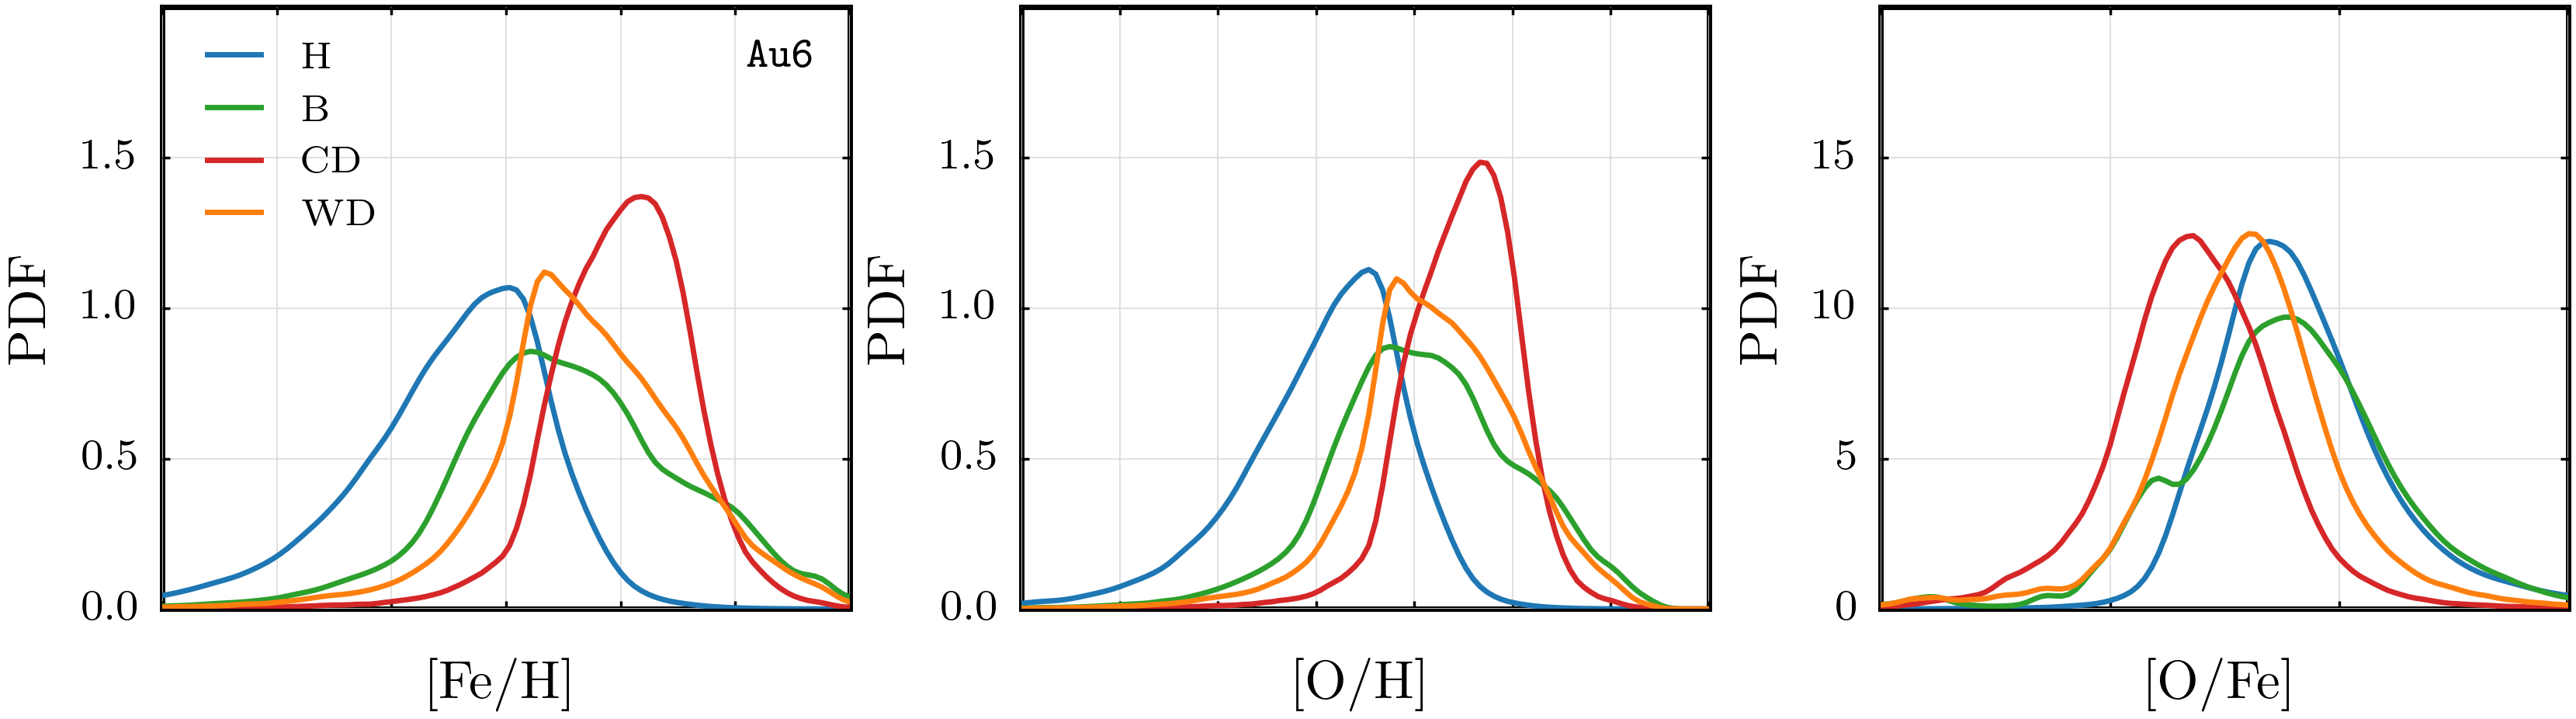

In [69]:
simulation = sample[3]
data = pd.read_csv(f"../results/{'_'.join(simulation.split('_')[:-1])}/"
                   f"stellar_abundance_distribution.csv")

fig = plt.figure(figsize=(8.0, 2.0))
gs = fig.add_gridspec(nrows=1, ncols=3, hspace=0.0, wspace=0.25)
axs = gs.subplots(sharex=False, sharey=False)

for j in range(len(abundances)):
    ax = axs[j]
    ax.tick_params(which='both', direction="in")
    ax.set_ylim(ylims[j])
    ax.set_xlim(abundance_lims[j])
    ax.set_xticks(xticks[j])
    ax.set_xticklabels([])
    ax.set_yticks(yticks[j])
    ax.set_xlabel(f'[{abundances[j][0]}/{abundances[j][1]}]')
    ax.set_ylabel("PDF")
    ax.grid(True, ls='-', lw=0.25, c="gainsboro")

galaxy = parse(simulation)[0]
for j, (of, to) in enumerate(abundances):
    for i, c in enumerate(settings.components):
        color = settings.component_colors[c]
        ax = axs[j]
        ax.plot(data[f"Abundance_[{of}/{to}]"], data[f"PDF_[{of}/{to}]_{c}"],
                lw=1.0, color=color, zorder=16, label=c)

axs[0].legend(loc="upper left", framealpha=0, fontsize=7.0)
axs[0].text(
    x=0.95, y=0.95, size=8.0,
    s=r"$\texttt{" + f"Au{galaxy}" + "}$",
    ha='right', va='top', transform=axs[0].transAxes)

plt.show()

In [45]:
fig = plt.figure(figsize=(8.0, 6.0))
gs = fig.add_gridspec(nrows=4, ncols=3, hspace=0.0, wspace=0.25)
axs = gs.subplots(sharex=False, sharey=False)

for i, c in enumerate(settings.components):
    for j in range(len(abundances)):
        ax = axs[i, j]
        ax.tick_params(which='both', direction="in")
        ax.set_ylim(ylims[j])
        ax.set_xlim(xlims[j])
        ax.set_xticks(xticks[j])
        if not ax.get_subplotspec().is_last_row():
            ax.set_xticklabels([])
        ax.set_yticks(yticks[j])
        ax.set_xlabel(f'[{abundances[j][0]}/{abundances[j][1]}]')
        if ax.get_subplotspec().is_first_col():
            ax.set_ylabel("PDF")
        ax.grid(True, ls='-', lw=0.25, c="gainsboro")
        ax.text(
            x=0.05, y=0.95, size=8.0, ha="left", va="top",
            s=r"$\textbf{" + settings.component_labels[c] + "}$",
            c=settings.component_colors[c], transform=ax.transAxes)

medians = {}
for of, to in abundances:
    for c in settings.components:
        medians[f"{of}_{to}_{c}"] = np.zeros((len(sample), 100))

for s, simulation in enumerate(sample):
    galaxy = parse(simulation)[0]
    df = read_data_many(simulation, abundances, config)
    zorder = 16 if galaxy == 6 else 15
    label = f"Au{galaxy}" if galaxy == 6 else f"_Au{galaxy}"
    for j, (of, to) in enumerate(abundances):
        for i, c in enumerate(settings.components):
            color = settings.component_colors[c] if galaxy == 6 else "silver"
            ax = axs[i, j]
            is_region = df["RegionTag"] == i

            pdf = gaussian_kde(df[f"[{of}/{to}]"][is_region].to_numpy())
            pdf_x = np.linspace(ax.get_xlim()[0], ax.get_xlim()[1], 100)
            ax.plot(pdf_x, pdf(pdf_x), lw=1.0,
                    color=color, zorder=zorder, label=label)
            medians[f"{of}_{to}_{c}"][s, :] = pdf(pdf_x)

for j, (of, to) in enumerate(abundances):
    for i, c in enumerate(settings.components):
        color = settings.component_colors[c]
        ax = axs[i, j]
        is_region = df["RegionTag"] == i
        pdf = gaussian_kde(df[f"[{of}/{to}]"][is_region].to_numpy())
        pdf_x = np.linspace(ax.get_xlim()[0], ax.get_xlim()[1], 100)
        ax.plot(pdf_x, np.nanmedian(medians[f"{of}_{to}_{c}"], axis=0),
                lw=1.0, color=color, zorder=16, label="Median",
                ls=(0, (5, 1)))

for ax in axs.flatten():
    l = ax.legend(loc="upper left", framealpha=0, fontsize=7.0,
                  bbox_to_anchor=(0.01, 0.9), bbox_transform=ax.transAxes)
    l.set_zorder(20)

fig.savefig(
    f"../images/metal_abundance_distribution/"
    f"included_2dpanels{config['FILE_SUFFIX']}.pdf")
plt.close(fig)